In [110]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import shap
import matplotlib.pyplot as plt
import astartes
from vsa_explainer import visualize_vsa_contributions
# Config
DATA_PATH = "B3DB_regression.tsv"
SMILES_COL = "SMILES"
TARGET_COL = "logBB"
RANDOM_STATE = 142

plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.sans-serif': 'Segoe UI'})
plt.rcParams.update({'font.size': 26})

ModuleNotFoundError: No module named 'vsa_explainer'

In [57]:
def compute_descriptors(mol, descriptor_names):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    return calc.CalcDescriptors(mol)

In [46]:
# Load dataset
df = pd.read_csv(DATA_PATH, sep = '\t')
df = df.dropna(subset=[SMILES_COL, TARGET_COL])

# Convert SMILES to RDKit mol
df["mol"] = df[SMILES_COL].apply(Chem.MolFromSmiles)
df = df[df["mol"].notna()].reset_index(drop=True)

# Compute all RDKit descriptors if not cached
cached_file = "descriptor_cache.csv"
try:
    X = pd.read_csv(cached_file)
    print("Loaded cached descriptors.")
except FileNotFoundError:
    descriptor_names = [d[0] for d in Descriptors.descList]
    print(f"Calculating {len(descriptor_names)} descriptors for {len(df)} molecules...")
    X = pd.DataFrame([compute_descriptors(m, descriptor_names) for m in df["mol"]], columns=descriptor_names)
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    X.to_csv(cached_file, index=False)

Loaded cached descriptors.


In [51]:
y = df[TARGET_COL].astype(float)
# Scaffold split using astartes
splits = astartes.train_test_split(
    df[SMILES_COL], return_indices=True, test_size=0.2, random_state=RANDOM_STATE, sampler = 'scaffold'
)
train_idx, test_idx = splits[4], splits[5]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\astartes\utils\array_type_helpers.py:19: ConversionWarning: Attempting to cast X to a numpy array, which may result in unexpected behavior (remove this warning by passing numpy arrays directly to astartes).
  warnings.warn(
C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\astartes\main.py:348: NormalizationWarning: Requested train/test split (0.75, 0.20) do not sum to 1.0, normalizing to train=0.79, test=0.21.
  warn(
C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\astartes\samplers\extrapolation\scaffold.py:48: NoMatchingScaffold: No matching scaffold was found for the 117 molecules corresponding to indices {517, 1036, 525, 1037, 527, 1038, 1040, 1048, 539, 549, 40, 566, 571, 572, 577, 584, 588, 597, 598, 599, 600, 601, 602, 603, 605, 97, 613, 104, 619, 630, 634, 125, 640, 642, 643, 644, 133, 653, 143, 144, 147, 662, 666, 667, 668, 160, 681, 172, 684, 685, 181, 697, 699, 710, 

In [52]:
# Train Random Forest model
rf = RandomForestRegressor(n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1,
                           max_depth = 20)
rf.fit(X_train, y_train)

# Model evaluation
y_pred = rf.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred))
print("Test r:", pearsonr(y_test, y_pred)[0])

Test RMSE: 0.3253584309702566
Test r: 0.7164749455721249


p = 0.0000


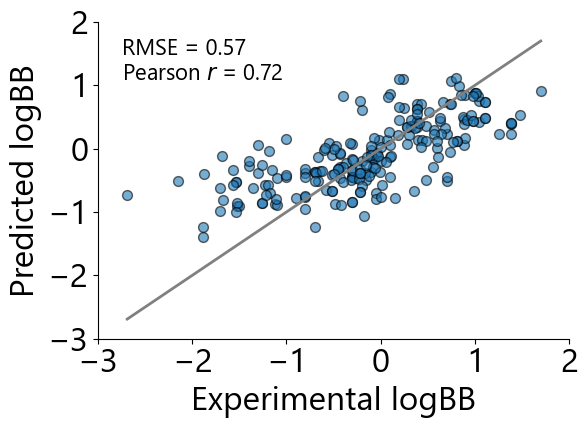

In [98]:
# Parity plot
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.scatter(y_test, y_pred, color = "tab:blue", alpha=0.6, edgecolor="black", s = 50)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, "gray", linewidth=2)
ax.set_xlim([-3, 2])
ax.set_xticks([-3, -2, -1, 0, 1, 2])
ax.set_ylim([-3, 2])
ax.set_yticks([-3, -2, -1, 0, 1, 2])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r = pearsonr(y_test, y_pred)
r_value = r[0]
plt.text(0.05, 0.95,
         f"RMSE = {rmse:.2f}\nPearson $r$ = {r_value:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment="top",
         fontsize=16,
         )
print(f'p = {r[1]:.4f}')
plt.xlabel("Experimental logBB")
plt.ylabel("Predicted logBB")
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

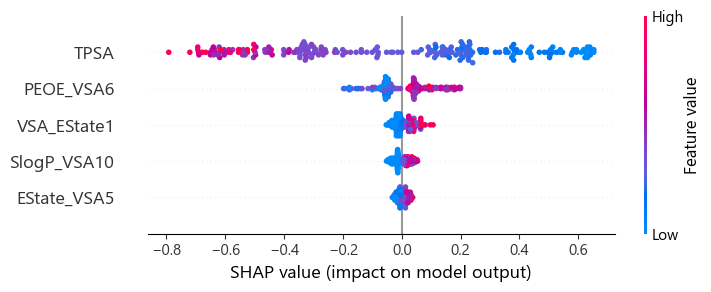

In [ ]:
# SHAP explanations
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
# SHAP summary plot (beeswarm)
plt.figure(figsize=(6.4, 4.8))
shap.summary_plot(shap_values, X_test, show=True, max_display=5)

In [109]:
#Visualize PEOE_VSA6 contributions for the molecule with the highest and lowest logBB
max_row = df.loc[df[TARGET_COL].idxmax()]
min_row = df.loc[df[TARGET_COL].idxmin()]

molecule_max = max_row[SMILES_COL]
molecule_min = min_row[SMILES_COL]

visualize_vsa_contributions(molecule_max, ["PEOE_VSA6"])
visualize_vsa_contributions(molecule_min, ["PEOE_VSA6"])

NameError: name 'visualize_vsa_contributions' is not defined